# CSE 622 Final Project
Spring 2023  
E Tracy

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygame as pg
from scipy import signal
import pandas as pd

pygame 2.3.0 (SDL 2.24.2, Python 3.11.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Social Dynamics Class

In [14]:
# Class for holding number values corresponding to distinct cell states
class States:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
# class for simulating the Cellular Automata
class SocialDynamics:
    def __init__(self, screen, target_fps, room_size, draw=True, max_gen=np.inf, seed=None):
        self.screen = screen
        self.target_fps = target_fps
        self.max_gen = max_gen
        self.draw = draw
        self.clock = pg.time.Clock()
        self.w  = room_size[0]
        self.h = room_size[1]
        self.room_window = pg.Surface(room_size)
        self.states = States(
            dead = 0,
            neutral = 1,
            unhappy = 2,
            happy = 3
        )
        self.colors = [0]*len(self.states.__dict__)
        self.colors[self.states.dead] = (0, 0, 0)
        self.colors[self.states.neutral] = (0, 0, 255)
        self.colors[self.states.unhappy] = (255, 0, 0)
        self.colors[self.states.happy] = (0, 255, 0)
        # used for randomly setting cell states at t=0
        self.p_neutral_init = 0.05
        self.p_happy_init = 0.05
        self.p_unhappy_init = 0.05
        self.p_dead_init = 1-(self.p_happy_init+self.p_neutral_init+self.p_unhappy_init)
        self.rand = np.random.default_rng(seed=seed)
        self.generation = 0
        self.n_cells_changed = 0
        self.n_cells_alive = 0
        # used in helper functions to find neighbors
        self.nbmask = np.array([[1,1,1],[1,0,1],[1,1,1]]) # moore neighborhood
        self.popdata = pd.DataFrame(columns=['generation','happy','unhappy','neutral','alive','change'])
        self.popdata.sort_index(inplace=True)
        self.max_history = 10
        self.birth_probs = self.rand.uniform(0.1,0.3, size=3).tolist()
        self.birth_probs.insert(0,1-sum(self.birth_probs))
        self.paused = False
        self.intitial_probs = [self.p_dead_init,
                 self.p_neutral_init,
                 self.p_unhappy_init,
                 self.p_happy_init]
    
    def run(self):
        self.running = True
        step_once = False
        state_selected = 0
        while self.running:
            # handle events
            for event in pg.event.get():
                if event.type == pg.QUIT:
                    self.running = False
                elif event.type == pg.KEYDOWN:
                    if event.key == pg.K_ESCAPE:
                        self.running = False
                    if event.key == pg.K_SPACE:
                        self.paused = not self.paused
                    if event.key == pg.K_n:
                        step_once = True
                    if event.key == pg.K_r:
                        self.setup_room()
                elif event.type == pg.MOUSEBUTTONDOWN:
                    # left mouse button sets the current cell to the selected state
                    if event.button == pg.BUTTON_LEFT:
                        x,y = pg.mouse.get_pos()
                        x = int(self.w * x / self.screen.get_rect().size[0])
                        y = int(self.h * y / self.screen.get_rect().size[1])
                        self.room[x+1,y+1] = state_selected
                    # right mouse button cycles the selected state
                    elif event.button == pg.BUTTON_RIGHT:
                        state_selected = state_selected + 1 if state_selected < 3 else 0
                        print("selected state:",["dead","neutral","unhappy","happy"][state_selected])
                elif event.type == pg.MOUSEMOTION:
                    # record cursor position for drawing it later
                    x,y = pg.mouse.get_pos()
                    mx = int(self.w * x / self.screen.get_rect().size[0])
                    my = int(self.h * y / self.screen.get_rect().size[1])                    
            
            # handle game logic here                     
            if self.draw:
                # draw to the grid
                self.plot_life()
                
                # update cursor
                while self.screen.get_locked():
                    self.screen.unlock()
                if 'mx' in locals() and 'my' in locals():
                    rgbarr = pg.surfarray.pixels2d(self.room_window)
                    rgbarr[mx,my] = self._get_24bit_color(self.colors[state_selected])
                    self.screen.blit(pg.transform.scale(self.room_window, self.screen.get_rect().size), (0,0))
            
            if self.paused:
                if step_once:
                    step_once = False
                    self.new_generation()
                pg.time.wait(10)
            else:
                self.new_generation()
            
            if self.draw:            
                # screen locks
                while self.screen.get_locked():
                    self.screen.unlock()
                # update the screen
                pg.display.flip()
                # limit the fps
                self.clock.tick(self.target_fps)

    def new_generation(self):
        # create a new generation using the ruleset
        self.generation += 1
        w,h = self.w,self.h

        self._record_history()
        
        happy_neighbors = signal.convolve2d(self.room==self.states.happy, self.nbmask, mode='same')[1:w+1, 1:h+1]
        unhappy_neighbors = signal.convolve2d(self.room==self.states.unhappy, self.nbmask, mode='same')[1:w+1, 1:h+1]
        neighbor_count = signal.convolve2d(self.room>0, self.nbmask, mode='same')[1:w+1, 1:h+1]
        
        new_room = np.zeros_like(self.room)
        
        # rule 1
        new_room[1:w+1, 1:h+1][(self.room[1:w+1, 1:h+1]==self.states.happy)\
                                &(unhappy_neighbors[:,:]>0)] = self.states.unhappy 
        # rule 2
        new_room[1:w+1, 1:h+1][(self.room[1:w+1, 1:h+1]==self.states.happy)\
                                &(neighbor_count[:,:]==2)] = self.states.neutral
        # rule 3
        new_room[1:w+1, 1:h+1][(self.room[1:w+1, 1:h+1]==self.states.unhappy)\
                                &(happy_neighbors[:,:]>0)] = self.states.happy
        # rule 4
        new_room[1:w+1, 1:h+1][(self.room[1:w+1, 1:h+1]==self.states.unhappy)\
                                &(neighbor_count[:,:]==2)] = self.states.neutral
        # rule 5
        new_room[1:w+1, 1:h+1][(self.room[1:w+1, 1:h+1]==self.states.neutral)\
                                &(happy_neighbors[:,:]>unhappy_neighbors[:,:])] = self.states.happy
        # rule 6
        new_room[1:w+1, 1:h+1][(self.room[1:w+1, 1:h+1]==self.states.neutral)\
                                &(happy_neighbors[:,:]<unhappy_neighbors[:,:])] = self.states.unhappy
        # rule 7
        birth_mask = (self.room[1:w+1, 1:h+1] == self.states.dead) & (neighbor_count[:,:]==3)
        new_room[1:w+1,1:h+1] += birth_mask[:,:] * self._gen_random_room(w,h,self.choices, self.birth_probs)[1:w+1,1:h+1]
        # rule 8
        new_room[1:w+1, 1:h+1][(neighbor_count[:,:]>4) | (neighbor_count[:,:] == 0)] = self.states.dead
        
        self.room = new_room
        self._update_borders()
        
        # perform life counts
        check_frequency = 5 # every n generations
        if self.generation % check_frequency == 0:
            self.n_cells_changed = (self.roomhistory[0][1:w+1, 1:h+1] != self.room[1:w+1, 1:h+1]).sum()
            self.n_cells_alive = np.count_nonzero(self.room)
            n_happy = np.count_nonzero(self.room==self.states.happy)
            n_unhappy = np.count_nonzero(self.room==self.states.unhappy)
            n_neutral = np.count_nonzero(self.room==self.states.neutral)
            self.popdata.loc[len(self.popdata.index)] = [self.generation, n_happy, n_unhappy, n_neutral, self.n_cells_alive, self.n_cells_changed]
            if self._stability():
                # self.paused=True
                self.running=False
            if self.generation > self.max_gen:
                self.running=False         
        
    def _update_borders(self):
        w,h = self.w, self.h
        # handle wrapping edges around to other sides
        ## second to bottommost row is copied into top border row
        self.room[0:1, :] = self.room[w:w+1, :]
        ## second to topmost row is copied into bottom border row
        self.room[w+1:w+2, :] = self.room[1:2, :]
        ## second to rightmost column is copied into left border column
        self.room[:, 0:1] = self.room[:, h:h+1]
        ## second to leftmost column is copied into right border column
        self.room[:, h+1:h+2] = self.room[:, 1:2]
    
    def plot_life(self):
        while self.screen.get_locked():
            self.screen.unlock()
        w,h = self.w, self.h
        rgbarr = pg.surfarray.pixels2d(self.room_window)
        rgbarr[:,:] = 0
        rgbarr[:,:][self.room[1:w+1, 1:h+1]==self.states.happy] = self._get_24bit_color(self.colors[self.states.happy])
        rgbarr[:,:][self.room[1:w+1, 1:h+1]==self.states.unhappy] = self._get_24bit_color(self.colors[self.states.unhappy])
        rgbarr[:,:][self.room[1:w+1, 1:h+1]==self.states.neutral] = self._get_24bit_color(self.colors[self.states.neutral])
        self.screen.blit(pg.transform.scale(self.room_window, self.screen.get_rect().size),(0,0))
    
    def _get_24bit_color(self, color : tuple):
        if len(color) != 3:
            return 0
        # given 8 bit color in rgb, 
        # 24bit_color = 256^2 r + 256 g + b 
        return color[0] * 256 ** 2 + color[1] * 256 + color[2]
    
    def _gen_random_room(self, w, h, choices, probs):
        return self.rand.choice(a=choices,
                                     size=(w+2,h+2),
                                     p=probs,
                                     replace=True).astype(np.uint8)
    
    def _record_history(self):
        self.roomhistory.insert(0,self.room.copy())
        if len(self.roomhistory) > self.max_history:
            self.roomhistory.pop()
        
    def _stability(self):
        if len(self.roomhistory) < self.max_history:
            return False
        if np.count_nonzero(self.roomhistory[0]) != np.count_nonzero(self.room):
            return False
        for i in range(len(self.roomhistory) - 1):
            moment = self.roomhistory[i]
            prevmoment = self.roomhistory[i+1]
            if np.count_nonzero(moment) != np.count_nonzero(prevmoment):
                return False
        return True
        
    def setup_room(self):
        # init the array to be the size of the room plus a 1 pixel border for wrapping around (toroid topology)
        w,h = self.w, self.h
        self.choices = [self.states.dead,
                   self.states.neutral,
                   self.states.unhappy,
                   self.states.happy]
        self.room = self._gen_random_room(w,h,self.choices,self.intitial_probs)

        self._update_borders()
        # used for determining amount of cells that have changed in the current generation
        self.check_room = self.room.copy()
        self.roomhistory = []
        self.gen = 0
        self.n_cells_changed = 0
        self.n_cells_alive = np.count_nonzero(self.room)
        n_happy = np.count_nonzero(self.room==self.states.happy)
        n_unhappy = np.count_nonzero(self.room==self.states.unhappy)
        n_neutral = np.count_nonzero(self.room==self.states.neutral)
        self.popdata.loc[len(self.popdata.index)] = [self.generation, n_happy, n_unhappy, n_neutral, self.n_cells_alive, self.n_cells_changed]


# Run Single Simulation

1984 generations  [0.35514999999999997, 0.21495, 0.21495, 0.21495]


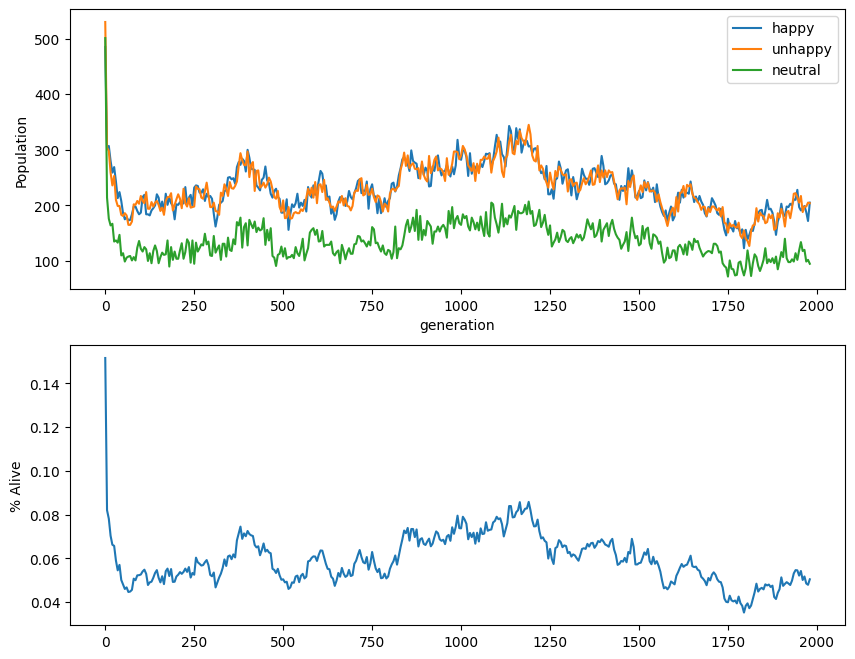

In [15]:
pg.display.init()
disp_size = (900, 900)
room_size = (100,100)
screen = pg.display.set_mode(disp_size, pg.DOUBLEBUF)
pg.display.set_caption("Social Dynamics")
sd = SocialDynamics(screen, 20, room_size, draw=True, max_gen=50_000, seed=None)
# Set birth probabilities
sd.birth_probs = [0.21495]*3 # this leads to decently varied population durations
sd.birth_probs.insert(0, 1-sum(sd.birth_probs))
# sd.paused = True # uncomment to start paused
# sd.intitial_probs = [0.94, 0.02, 0.02, 0.02]
sd.setup_room()
sd.run()
pg.quit()
print(sd.generation,'generations ',sd.birth_probs)

# visualizations
fig, ax = plt.subplots(2)
fig.set_figheight(8)
fig.set_figwidth(10)
sd.popdata.plot(x='generation', y=['happy','unhappy','neutral'],kind='line', ax=ax[0])
fig.axes[0].set_ylabel("Population")
ax[1] = plt.plot(sd.popdata['generation'], sd.popdata['alive'] / (room_size[0]*room_size[1]))
fig.axes[1].set_ylabel("% Alive")
plt.show()

# Run Multiple Simulations

## Initialize Results Storage DataFrame

In [60]:
results = pd.DataFrame(columns=['generations', 'pdead', 'pneutral', 'punhappy','phappy'])
results.sort_index(inplace=True)

## Run

In [61]:
import time
for i in range(400):
    start = time.time()
    pg.display.init()
    disp_size = (900, 900)
    room_size = (100,100)
    screen = pg.display.set_mode(disp_size, pg.DOUBLEBUF)
    pg.display.set_caption("Social Dynamics")
    sd = SocialDynamics(screen, 1000, room_size, draw=False, max_gen=50_000)
    sd.setup_room()
    sd.run()
    pg.quit()
    results.loc[len(results.index)] = [sd.generation]+sd.birth_probs
    end = time.time()
    print("trial",i,'',sd.generation,'generations', '', end-start, 'seconds','', sd.generation/(end-start), 'gen/sec')
    results.to_csv('results.csv')

trial 0  95 generations  0.13983511924743652 seconds  679.37153778872 gen/sec
trial 1  115 generations  0.16007709503173828 seconds  718.4038414565125 gen/sec
trial 2  50005 generations  64.8597137928009 seconds  770.9716413449592 gen/sec
trial 3  130 generations  0.18784213066101074 seconds  692.0705144396198 gen/sec
trial 4  135 generations  0.18502259254455566 seconds  729.6406246577178 gen/sec
trial 5  50005 generations  64.2323670387268 seconds  778.5015920377201 gen/sec
trial 6  50005 generations  66.53313899040222 seconds  751.5803516682641 gen/sec
trial 7  50005 generations  63.365145683288574 seconds  789.1562381933878 gen/sec
trial 8  1400 generations  1.728874683380127 seconds  809.7752910944689 gen/sec
trial 9  185 generations  0.24880552291870117 seconds  743.55262628334 gen/sec
trial 10  50005 generations  64.83753848075867 seconds  771.2353240374724 gen/sec
trial 11  50005 generations  64.82112765312195 seconds  771.4305784310377 gen/sec
trial 12  140 generations  0.1944

## Run this to save results

In [ ]:
results.to_csv('results.csv')